In [1]:
#Cell 1 — Imports
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report


C:\Users\Admin\SAS-sign-to-text\sasl\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
#Cell 2 — Paths + dataset loader (VAL only)
MODEL_PATH = "sasl_mobilenet_v2.keras"   # same folder as this notebook
VAL_DIR    = r"C:/Users/Admin/SAS-sign-to-text/Data/val"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 123

val_ds = keras.utils.image_dataset_from_directory(
    VAL_DIR,
    labels="inferred",
    label_mode="categorical",   # one-hot
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = val_ds.class_names
num_classes = len(class_names)

print("Classes:", class_names)
print("Num classes:", num_classes)


Found 4268 files belonging to 27 classes.
Classes: ['0', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Num classes: 27


In [3]:
#Cell 3 — (Important) Convert images to grayscale then back to 3-channel
AUTOTUNE = tf.data.AUTOTUNE

def make_grayscale_3ch(images, labels):
    gray = tf.image.rgb_to_grayscale(images)     # (B,224,224,1)
    gray3 = tf.repeat(gray, repeats=3, axis=-1)  # (B,224,224,3)
    return gray3, labels

val_ds = val_ds.map(make_grayscale_3ch, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)


In [4]:
#Cell 4 — Load model
model = keras.models.load_model(MODEL_PATH)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 27)             │        34,587 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,361,747 (9.01 MB)

 Trainable params: 34,587 (135.11 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 69,176 (270.22 KB)

In [5]:
#Cell 5 — Get predictions + confusion matrix
y_true = []
y_pred = []

for x, y in val_ds:
    preds = model.predict(x, verbose=0)               # (B, num_classes)
    y_true.extend(np.argmax(y.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix shape:", cm.shape)


Confusion matrix shape: (27, 27)


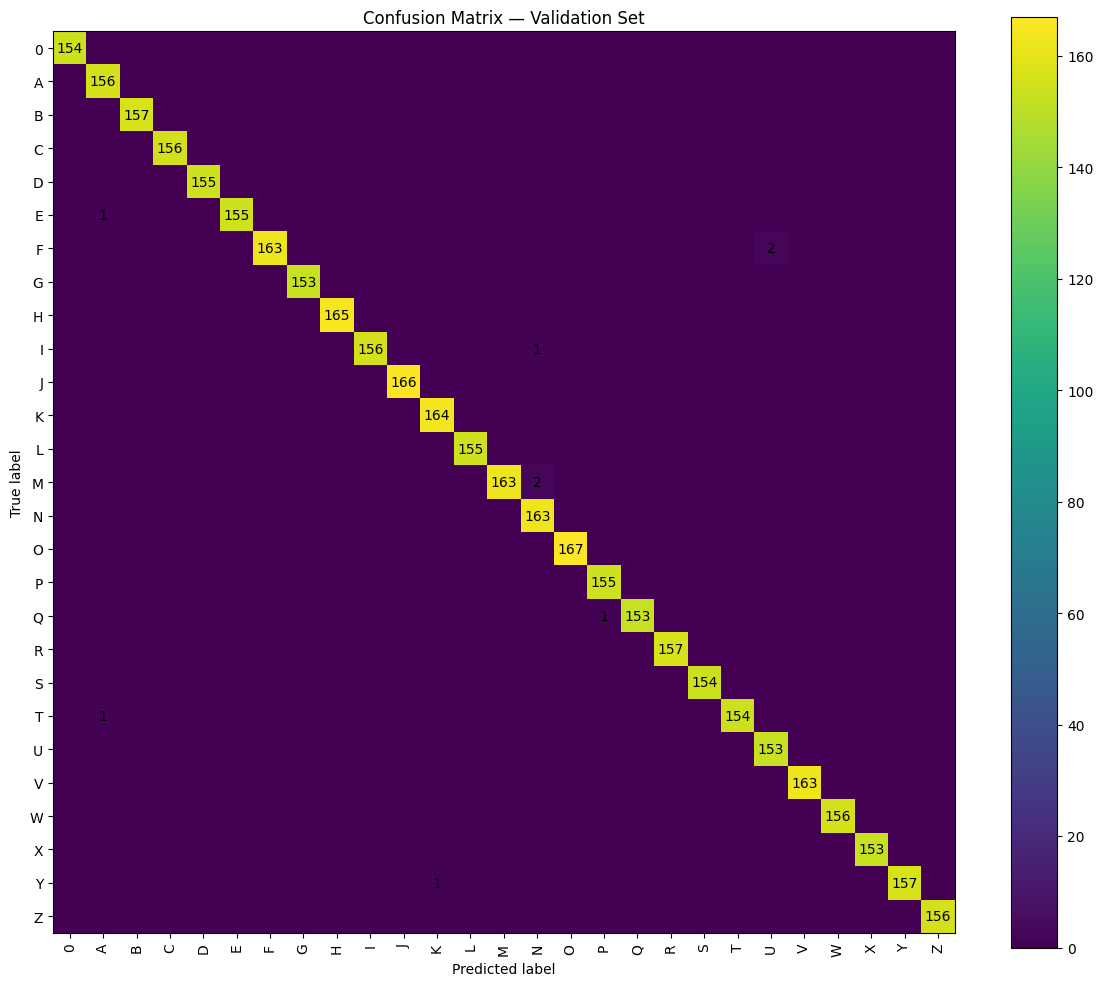

In [6]:
#Cell 6 — Plot confusion matrix (counts)
plt.figure(figsize=(12, 10))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix — Validation Set")
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)

# draw numbers (optional)
thresh = cm.max() * 0.5
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        val = cm[i, j]
        if val > 0:
            plt.text(j, i, str(val), ha="center", va="center")

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()


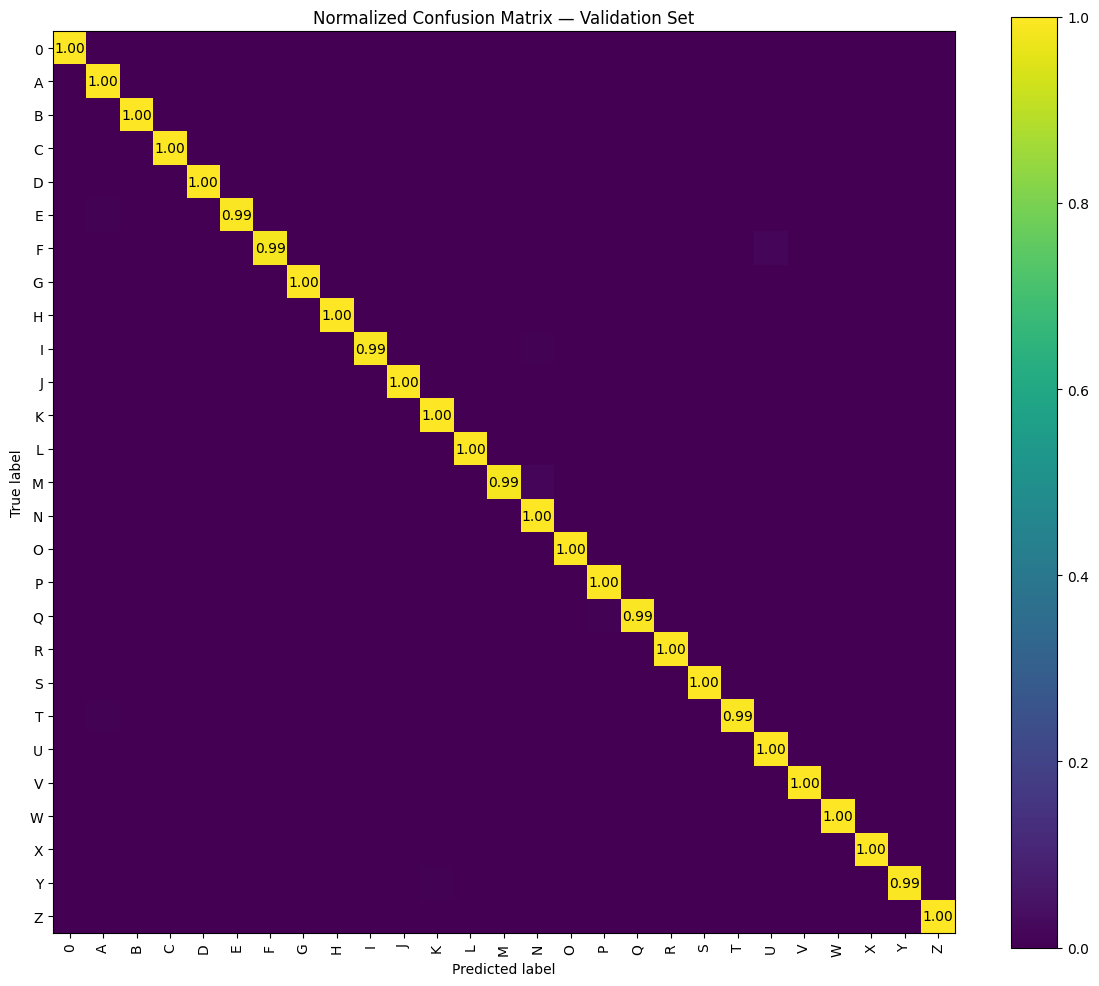

In [7]:
#Cell 7 — Plot normalized confusion matrix (percent per class)
cm_norm = cm.astype("float") / (cm.sum(axis=1, keepdims=True) + 1e-9)

plt.figure(figsize=(12, 10))
plt.imshow(cm_norm, interpolation="nearest", vmin=0.0, vmax=1.0)
plt.title("Normalized Confusion Matrix — Validation Set")
plt.colorbar()

plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)

# show a few decimals (optional)
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        val = cm_norm[i, j]
        if val >= 0.05:  # only write larger values to reduce clutter
            plt.text(j, i, f"{val:.2f}", ha="center", va="center")

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()


In [8]:
#Cell 8 — Classification report (precision/recall per class)
print(classification_report(
    y_true, y_pred,
    target_names=class_names,
    digits=4
))


              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       154
           A     0.9873    1.0000    0.9936       156
           B     1.0000    1.0000    1.0000       157
           C     1.0000    1.0000    1.0000       156
           D     1.0000    1.0000    1.0000       155
           E     1.0000    0.9936    0.9968       156
           F     1.0000    0.9879    0.9939       165
           G     1.0000    1.0000    1.0000       153
           H     1.0000    1.0000    1.0000       165
           I     1.0000    0.9936    0.9968       157
           J     1.0000    1.0000    1.0000       166
           K     0.9939    1.0000    0.9970       164
           L     1.0000    1.0000    1.0000       155
           M     1.0000    0.9879    0.9939       165
           N     0.9819    1.0000    0.9909       163
           O     1.0000    1.0000    1.0000       167
           P     0.9936    1.0000    0.9968       155
           Q     1.0000    